# Results visualization

In [3]:
# dataframe management
import os.path
import time

import numpy as np
import pandas as pd
from pyomo.environ import *
from sklearn import datasets
from sklearn import preprocessing
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from sklearn.metrics import completeness_score, homogeneity_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sorct import SORCT
from src.cluster import HierarchicalLogisticRegression, best_leaf_assignment
from src.utils import get_number_of_iterations
from sklearn.model_selection import KFold
from src.cluster import find_best_estimator
from pyomo.opt import SolverStatus, TerminationCondition
import pickle
import run_tests

In [4]:
res_path = "results"
names = ["car", "iris", "seeds_data", "new_thyroid", "splice"]
#names = ["iris"]
path = os.path.join(res_path, "{}_results.csv".format(names[0]))
df = pd.read_csv(path, sep=" ", index_col=0)
rob = pd.read_csv("results/iris_sorct.csv", sep=" ", index_col=0)
rob

,Time_0,Iterations_0,Score_0,Score_Train_0,Time_1,Iterations_1,Score_1,Score_Train_1,Time_2,Iterations_2,Score_2,Score_Train_2,Time_3,Iterations_3,Score_3,Score_Train_3,Time_4,Iterations_4,Score_4,Score_Train_4
SORCT,5.444753,223.0,0.6,0.741667,1.928741,103.0,0.733333,0.708333,6.216487,232.0,0.6,0.683333,0.181524,9.0,0.266667,0.35,2.528371,129.0,0.766667,0.7


In [5]:
roba = []
for file_index in range(len(names)):
    name = names[file_index]
    path = os.path.join(res_path, "{}_results.csv".format(name))
    df = pd.read_csv(path, sep=" ", index_col=0)
    roba.append(df)
index = 3
roba[index][[col for col in roba[index].columns if "Train" in col]]


,HLR_Score_Train_0,SORCT_Score_Train_0,HLR_Score_Train_1,SORCT_Score_Train_1,HLR_Score_Train_2,SORCT_Score_Train_2,HLR_Score_Train_3,SORCT_Score_Train_3,HLR_Score_Train_4,SORCT_Score_Train_4
kmeans,0.333333,0.600725,0.333333,0.606242,0.333333,0.617543,0.333333,0.597044,0.333333,0.599180
Agglomerative_sigle,0.333333,0.596339,0.333333,0.421177,0.333333,0.590526,0.333333,0.597044,0.333333,0.599061
birch,0.333333,0.609258,0.333333,0.606242,0.333333,0.462222,0.333333,0.597044,0.333333,0.599061
True_labels,0.806124,0.613916,0.796639,-1.000000,0.791893,0.590526,0.527769,0.597044,0.806341,0.622328


In [9]:
IGNORE_HLR_TIME = True
N_FOLDS = 5
dfs = []
for file_index in range(len(names)):
    name = names[file_index]
    path = os.path.join(res_path, "{}_results.csv".format(name))
    df = pd.read_csv(path, sep=" ", index_col=0)
    sorct_df = pd.read_csv(os.path.join(res_path,"{}_sorct.csv".format(name)), sep=" ", index_col=0)
    if -1 in df or -2 in df or -3 in df:
        print("Some folds were not computed")
    res_index = df.index
    res_index = res_index.append(sorct_df.index)
    result_df = pd.DataFrame(index=res_index)
    
    
    for cl_name in res_index:
        
        
        n_invalid = 0
        n_invalid_sorct = 0
        time = 0
        hlr_time = 0
        iters = 0
        hlr_score = 0
        sorct_score = 0
        hs = 0
        cp = 0
        sorct_train_score = 0
        hlr_train_score = 0
        # sorct no init values
        no_init_time = 0
        no_init_iters = 0
        no_init_score = 0
        no_init_train_score = 0
        for fold_index in range(N_FOLDS):
            if cl_name != "SORCT":
                if df.loc[cl_name,"Time_{}".format(fold_index)] < 0:
                    #print(name, cl_name, df.loc[cl_name,"Time_{}".format(fold_index)])
                    n_invalid += 1
                else:
                    time += df.loc[cl_name,"Time_{}".format(fold_index)]
                    if not IGNORE_HLR_TIME:
                        hlr_time += df.loc[cl_name, "HLR_Time_{}".format(fold_index)]
                    if df.loc[cl_name, "Iterations_{}".format(fold_index)] < 20:
                        print(name, cl_name, df.loc[cl_name, "Iterations_{}".format(fold_index)])
                        pass
                    iters += df.loc[cl_name, "Iterations_{}".format(fold_index)]
                    hlr_score += df.loc[cl_name, "HLR_Score_{}".format(fold_index)]
                    sorct_score += df.loc[cl_name, "SORCT_Score_{}".format(fold_index)]
                    hs += df.loc[cl_name, "Homogeneity_{}".format(fold_index)]
                    cp += df.loc[cl_name, "Completeness_{}".format(fold_index)]
                    sorct_train_score += df.loc[cl_name, "SORCT_Score_Train_{}".format(fold_index)]
                    hlr_train_score += df.loc[cl_name, "HLR_Score_Train_{}".format(fold_index)]
            # else sorct no init
            else:
                if  sorct_df.loc["SORCT", "Time_{}".format(fold_index) ] < 0:
                    n_invalid_sorct +=1
                    print(sorct_df.loc["SORCT", "Time_{}".format(fold_index) ])
                else:
                    no_init_time += sorct_df.loc["SORCT", "Time_{}".format(fold_index) ]
                    no_init_iters +=  sorct_df.loc["SORCT", "Iterations_{}".format(fold_index) ]
                    no_init_score +=  sorct_df.loc["SORCT", "Score_{}".format(fold_index) ]
                    no_init_train_score += sorct_df.loc["SORCT", "Score_Train_{}".format(fold_index) ]
        if cl_name != "SORCT":
            real_folds = N_FOLDS - n_invalid
            time = time / real_folds
            hlr_time = hlr_time / real_folds
            iters = iters / real_folds
            hlr_score = hlr_score / real_folds
            sorct_score = sorct_score / real_folds
            hs = hs / real_folds
            cp = cp / real_folds
            sorct_train_score = sorct_train_score / real_folds
            hlr_train_score = hlr_train_score / real_folds
            result_df.loc[cl_name, "Time"] = time
            if not IGNORE_HLR_TIME:
                result_df.loc[cl_name, "HLR_Time"] = hlr_time
            result_df.loc[cl_name, "Iterations"] = iters
            result_df.loc[cl_name, "Train_HLR_Score"] = hlr_train_score
            result_df.loc[cl_name, "Train_SORCT_Score"] = sorct_train_score
            result_df.loc[cl_name, "HLR_Score"] = hlr_score
            result_df.loc[cl_name, "SORCT_Score"] = sorct_score
            result_df.loc[cl_name, "Homogeneity"] = hs
            result_df.loc[cl_name, "Completeness"] = cp
            result_df.loc[cl_name, "Invalid Folds"] = n_invalid 
        else:
            n_folds_reals = N_FOLDS - n_invalid_sorct
            result_df.loc[cl_name, "Invalid Folds"] = n_invalid_sorct 
            result_df.loc[cl_name, "Time"] = no_init_time / n_folds_reals
            result_df.loc[cl_name, "Iterations"] = no_init_iters / n_folds_reals
            result_df.loc[cl_name, "SORCT_Score"] = no_init_score / n_folds_reals
            result_df.loc[cl_name, "Train_SORCT_Score"] = no_init_train_score / n_folds_reals

    #result_df["Invalid Folds"] = result_df["Invalid Folds"].astype("int32")
    dfs.append(result_df)
    result_df.to_csv(os.path.join(res_path, "{}_final.csv".format(name)), float_format='%.2f')
    
        
    

iris Agglomerative_sigle 18
seeds_data Agglomerative_sigle 7
seeds_data True_labels 7


In [7]:
for i in range(len(dfs)):
    dfs[i] = dfs[i].rename(index={"kmeans":"KMeans", "Agglomerative_sigle":"Agglomerative",
                          "birch":"Birch", "True_labels":"True Labels"})

In [8]:
dfs[1]

,Time,Iterations,Train_HLR_Score,Train_SORCT_Score,HLR_Score,SORCT_Score,Homogeneity,Completeness,Invalid Folds
KMeans,3.889652,182.40,0.025000,0.713333,0.040000,0.666667,6.068889e-01,0.763342,0.0
Agglomerative,3.480094,137.75,0.662500,0.625000,0.625000,0.591667,6.137732e-01,0.787724,1.0
Birch,4.914181,207.60,0.086667,0.713333,0.080000,0.666667,1.011898e-16,1.000000,0.0
True Labels,3.734610,157.75,0.635417,0.706250,0.616667,0.683333,1.000000e+00,1.000000,1.0
SORCT,3.259975,139.20,NaN,0.636667,NaN,0.593333,NaN,NaN,0.0


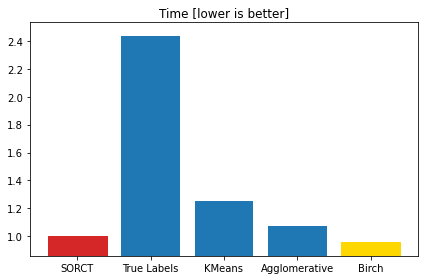

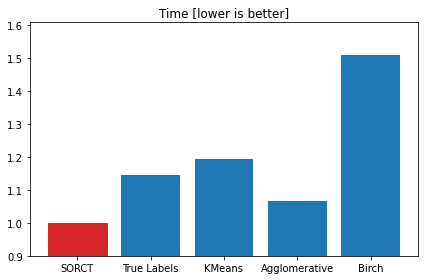

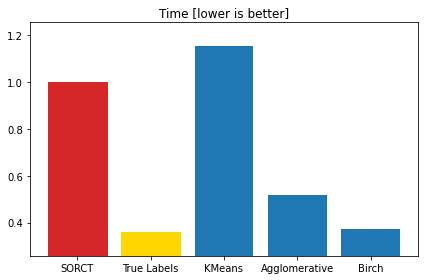

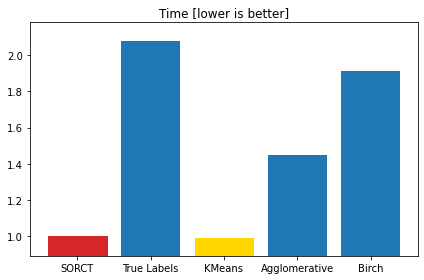

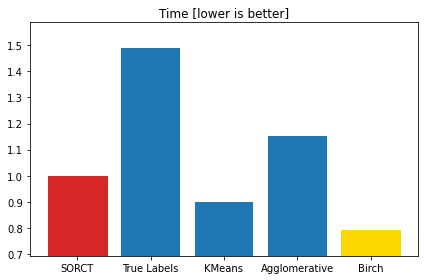

In [204]:
save = False
for i in range(len(dfs)):
    df = dfs[i]
    name = names[i]
    df = df.reindex(index = ['SORCT','True Labels','KMeans', "Agglomerative", "Birch"])
    index = list(df.index)
    fig, ax = plt.subplots()
    values = df["Time"]
    norm_values = values/values.loc["SORCT"]
    bars = ax.bar(index, norm_values)
    bars[0].set_color("tab:red")
    heights = [bars[i].get_height() for i in range(len(bars))]
    max_index = np.argmin(heights)
    if max_index != 0:
        bars[max_index].set_color("gold")
    ax.set_ylim([np.min(heights)-0.1,np.max(heights) + 0.1])
    ax.set_title("Time [lower is better]")
    plt.tight_layout()
    if save:
        fig.savefig("{}_time.png".format(name), dpi=720)


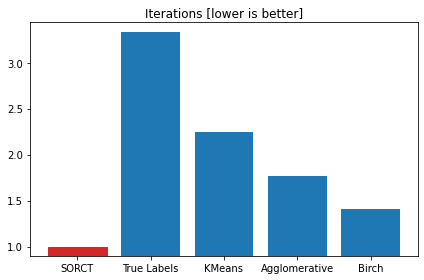

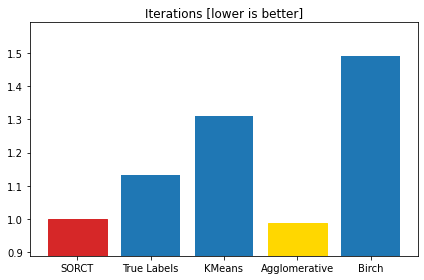

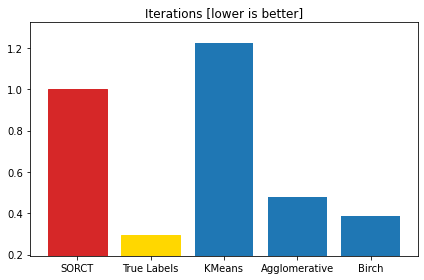

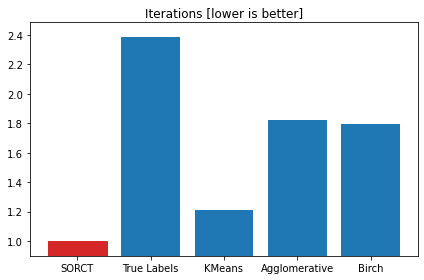

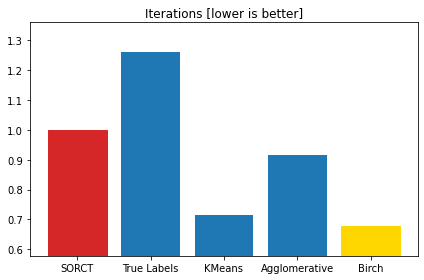

In [205]:
for i in range(len(dfs)):
    df = dfs[i]
    name = names[i]
    df = df.reindex(index = ['SORCT','True Labels','KMeans', "Agglomerative", "Birch"])
    index = list(df.index)
    fig, ax = plt.subplots()
    values = df["Iterations"]
    norm_values = values/values.loc["SORCT"]
    bars = ax.bar(index, norm_values)
    bars[0].set_color("tab:red")
    heights = [bars[i].get_height() for i in range(len(bars))]
    max_index = np.argmin(heights)
    if max_index != 0:
        bars[max_index].set_color("gold")
    ax.set_ylim([np.min(heights)-0.1,np.max(heights) + 0.1])
    ax.set_title("Iterations [lower is better]")
    plt.tight_layout()
    if save:
        fig.savefig("{}_iters.png".format(name), dpi=720)

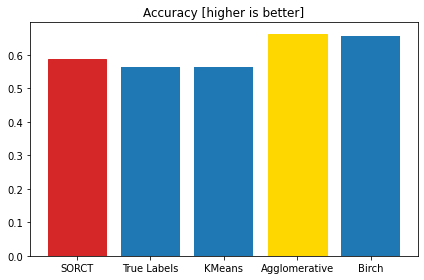

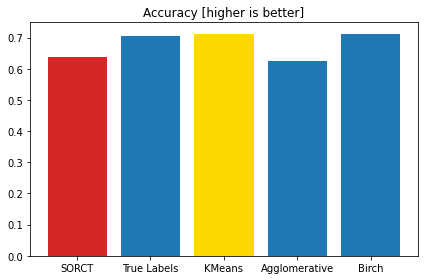

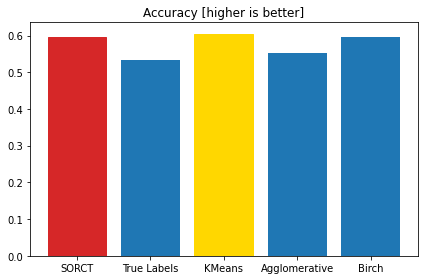

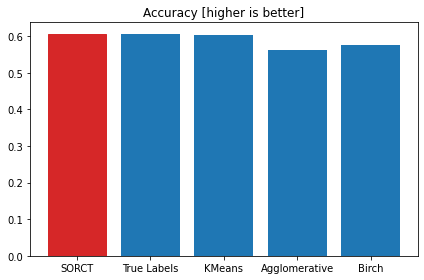

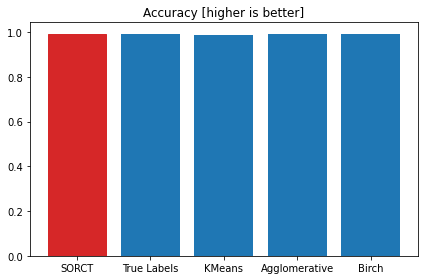

In [206]:
for i in range(len(dfs)):
    df = dfs[i]
    name = names[i]
    df = df.reindex(index = ['SORCT','True Labels','KMeans', "Agglomerative", "Birch"])
    index = list(df.index)
    fig, ax = plt.subplots()
    values = df["Train_SORCT_Score"]
    norm_values = values
    bars = ax.bar(index, norm_values)
    bars[0].set_color("tab:red")
    heights = [bars[i].get_height() for i in range(len(bars))]
    max_index = np.argmax(heights)
    if max_index != 0:
        bars[max_index].set_color("gold")
    #ax.set_ylim([np.min(heights)-0.05,np.max(heights) + 0.05])
    ax.set_title("Accuracy [higher is better]")
    plt.tight_layout()
    if save:
        fig.savefig("{}_accuracy.png".format(name), dpi=720)

In [ ]:
for df in dfs:
    index = list(df.index)
    fig, ax = plt.subplots()
    values = df["Iterations"]
    values = values/values.loc["SORCT"]
    ax.bar(index, values)

In [ ]:
ls results

## Test train set 

In [ ]:
dataset_name_list = ["car", "iris","new_thyroid", "seeds_data", "splice"]
N_SPLITS = 5
OPT_TYPE = "simple"
SEED = 1234
for dataset_name in dataset_name_list:
    if dataset_name == "iris":
        X, y = datasets.load_iris(as_frame=True, return_X_y=True)
        df = pd.DataFrame(X)
        df["Classes"] = y
    elif dataset_name == "car":
        dataset_path = os.path.join("datasets", "{}.csv".format(dataset_name))
        df = pd.read_csv(dataset_path, delimiter=";", header=0)
        df = df.convert_dtypes()
        # dictionary converting ordinal categories to values
        cost_dict = {"low": 0, "med": 1, "high": 2, "vhigh": 3}
        doors_dict = {"2": 2, "3": 3, "4": 4, "5more": 5}
        persons_dict = {"2": 2, "4": 4, "more": 5}
        dimension_dict = {"small": 0, "med": 1, "big": 2}
        # buying
        df["buying"] = df["buying"].apply(lambda x: cost_dict[x])
        df["maint"] = df["maint"].apply(lambda x: cost_dict[x])
        df["doors"] = df["doors"].apply(lambda x: doors_dict[x])
        df["persons"] = df["persons"].apply(lambda x: persons_dict[x])
        df["lug_boot"] = df["lug_boot"].apply(lambda x: dimension_dict[x])
        df["safety"] = df["safety"].apply(lambda x: cost_dict[x])
        classes_encoder = preprocessing.LabelEncoder().fit(df["Classes"])
        df["Classes"] = classes_encoder.transform(df["Classes"])
    else:
        dataset_path = os.path.join("datasets", "{}.csv".format(dataset_name))
        df = pd.read_csv(dataset_path, delimiter=";", header=0)
    if "Id" in df:
        df = df.drop('Id', axis=1)
    df_std = df.copy()
    scaler = MinMaxScaler()  # also MaxAbsScaler()
    # Preprocessing: we get the columns names of features which have to be standardized
    columns_names = list(df)
    index_features = list(range(0, len(df_std.columns) - 1))
    # The name of the classes K
    classes = df_std['Classes'].unique().tolist()
    classes_en = [i for i in range(len(classes))]
    # Encoder processing
    le = preprocessing.LabelEncoder()
    le.fit(df_std['Classes'])
    df_std['Classes'] = le.transform(df_std['Classes'])
    # Scaling phase
    df_std[columns_names[0:-1]] = scaler.fit_transform(df_std[columns_names[0:-1]])
    for column in columns_names[0:-1]:
        # TODO janky solution to unreliable MinMaxScaler behaviour
        df_std.loc[df[column] > 1, column] = 1
        df_std.loc[df[column] < 0, column] = 0

    X = df_std[columns_names[:-1]]
    y = df_std[columns_names[-1]]
    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    n_leaves = 4
    fold_index = 0
    for train_index, test_index in kf.split(X, y):
        print("Fold", fold_index)
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        df_train = pd.concat([X_train, y_train], axis=1)
        df_test = pd.concat([X_test, y_test], axis=1)
        # sample weightingsorct_iters
        occurences = [len(y_train[y_train == x]) for x in classes]
        total_samples = sum(occurences)
        sample_weight = np.zeros_like(y_train)
        for class_index, n_occurr in zip(classes, occurences):
            sample_weight[y_train == class_index] = n_occurr
        sample_weight = sample_weight / total_samples
        #HLR_car_Agglomerative_sigle_0.pkl
        # HLR
        # true labels
        filename = "HLR_{}_{}_{}.pkl".format("tl",dataset_name, fold_index)
        with open(os.path.join("results", filename), "rb") as f:
            hlr = pickle.load(f)
        run_tests.create_model()
        
        fold_index += 1

In [ ]:
ls results

In [ ]:
with open("results/SORCT_new_thyroid_birch_4.pkl", "rb") as f:
    roba = pickle.load(f)

In [ ]:
roba.keys()

In [ ]:
roba

In [ ]:
df_train.index[0]

In [ ]:
aa = pd.DataFrame(index=["a", "b", "c"])

In [ ]:
aa.loc["a","culo"] = 1

In [ ]:
aa

In [ ]:
aa.loc["d", "culo"] = 1

In [ ]:
aa.index.append(["e"])

In [9]:
import train_test

In [10]:
dataset_path = os.path.join("datasets", "car.csv")
df = pd.read_csv(dataset_path, delimiter=";", header=0)
df = df.convert_dtypes()
# dictionary converting ordinal categories to values
cost_dict = {"low": 0, "med": 1, "high": 2, "vhigh": 3}
doors_dict = {"2": 2, "3": 3, "4": 4, "5more": 5}
persons_dict = {"2": 2, "4": 4, "more": 5}
dimension_dict = {"small": 0, "med": 1, "big": 2}
# buying
df["buying"] = df["buying"].apply(lambda x: cost_dict[x])
df["maint"] = df["maint"].apply(lambda x: cost_dict[x])
df["doors"] = df["doors"].apply(lambda x: doors_dict[x])
df["persons"] = df["persons"].apply(lambda x: persons_dict[x])
df["lug_boot"] = df["lug_boot"].apply(lambda x: dimension_dict[x])
df["safety"] = df["safety"].apply(lambda x: cost_dict[x])
classes_encoder = preprocessing.LabelEncoder().fit(df["Classes"])
df["Classes"] = classes_encoder.transform(df["Classes"])

In [11]:
N_SPLITS = 4
SEED = 1234
n_feature = len(df.columns)-1
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
X = df[df.columns[0:n_feature]]
y = df["Classes"]
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    df_train = pd.concat([X_train, y_train], axis=1)
    df_test = pd.concat([X_test, y_test], axis=1)
    train_index = df_train.index
    break
train_index

Int64Index([   1,    2,    3,    5,    6,    7,    8,    9,   10,   12,
            ...
            1715, 1716, 1717, 1718, 1719, 1720, 1722, 1724, 1725, 1726],
           dtype='int64', length=1296)

In [12]:
filename = "HLR_tl_car_0.pkl"
with open(os.path.join("results", filename), "rb") as f:
    hlr_dict = pickle.load(f)
    


In [13]:
OPT_TYPE = "simple"
init  = train_test.get_model_init(hlr_dict, range(0,6), train_index, [0,1,2])
model = train_test.create_model(init, OPT_TYPE, df_train)
hlr_score = train_test.predict(model, X_train, y_train, dataset_name)

NameError: name 'classes_en' is not defined

## Clustering plots

In [64]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

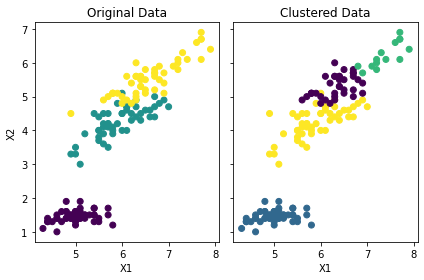

In [98]:
X, y = datasets.load_iris(as_frame=True, return_X_y=True)
df = pd.DataFrame(X)
df["Classes"] = y

km = KMeans(4).fit(X)

fig, ax = plt.subplots(1,2, sharey=True)

ax[0].scatter(X.iloc[:, 0], X.iloc[:, 2], c=y)
ax[0].set_title("Original Data")
ax[0].set_xlabel("X1")
ax[0].set_ylabel("X2")
ax[1].scatter(X.iloc[:, 0], X.iloc[:, 2], c=km.labels_)
ax[1].set_title("Clustered Data")
ax[1].set_xlabel("X1")
plt.tight_layout()
plt.show()
fig.savefig("kmeans_cluster.png", dpi=720)

In [77]:
from sklearn.metrics import completeness_score, homogeneity_score
homogeneity_score(y, km.labels_)

0.9423561478701509

In [86]:
y

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: target, Length: 150, dtype: int64